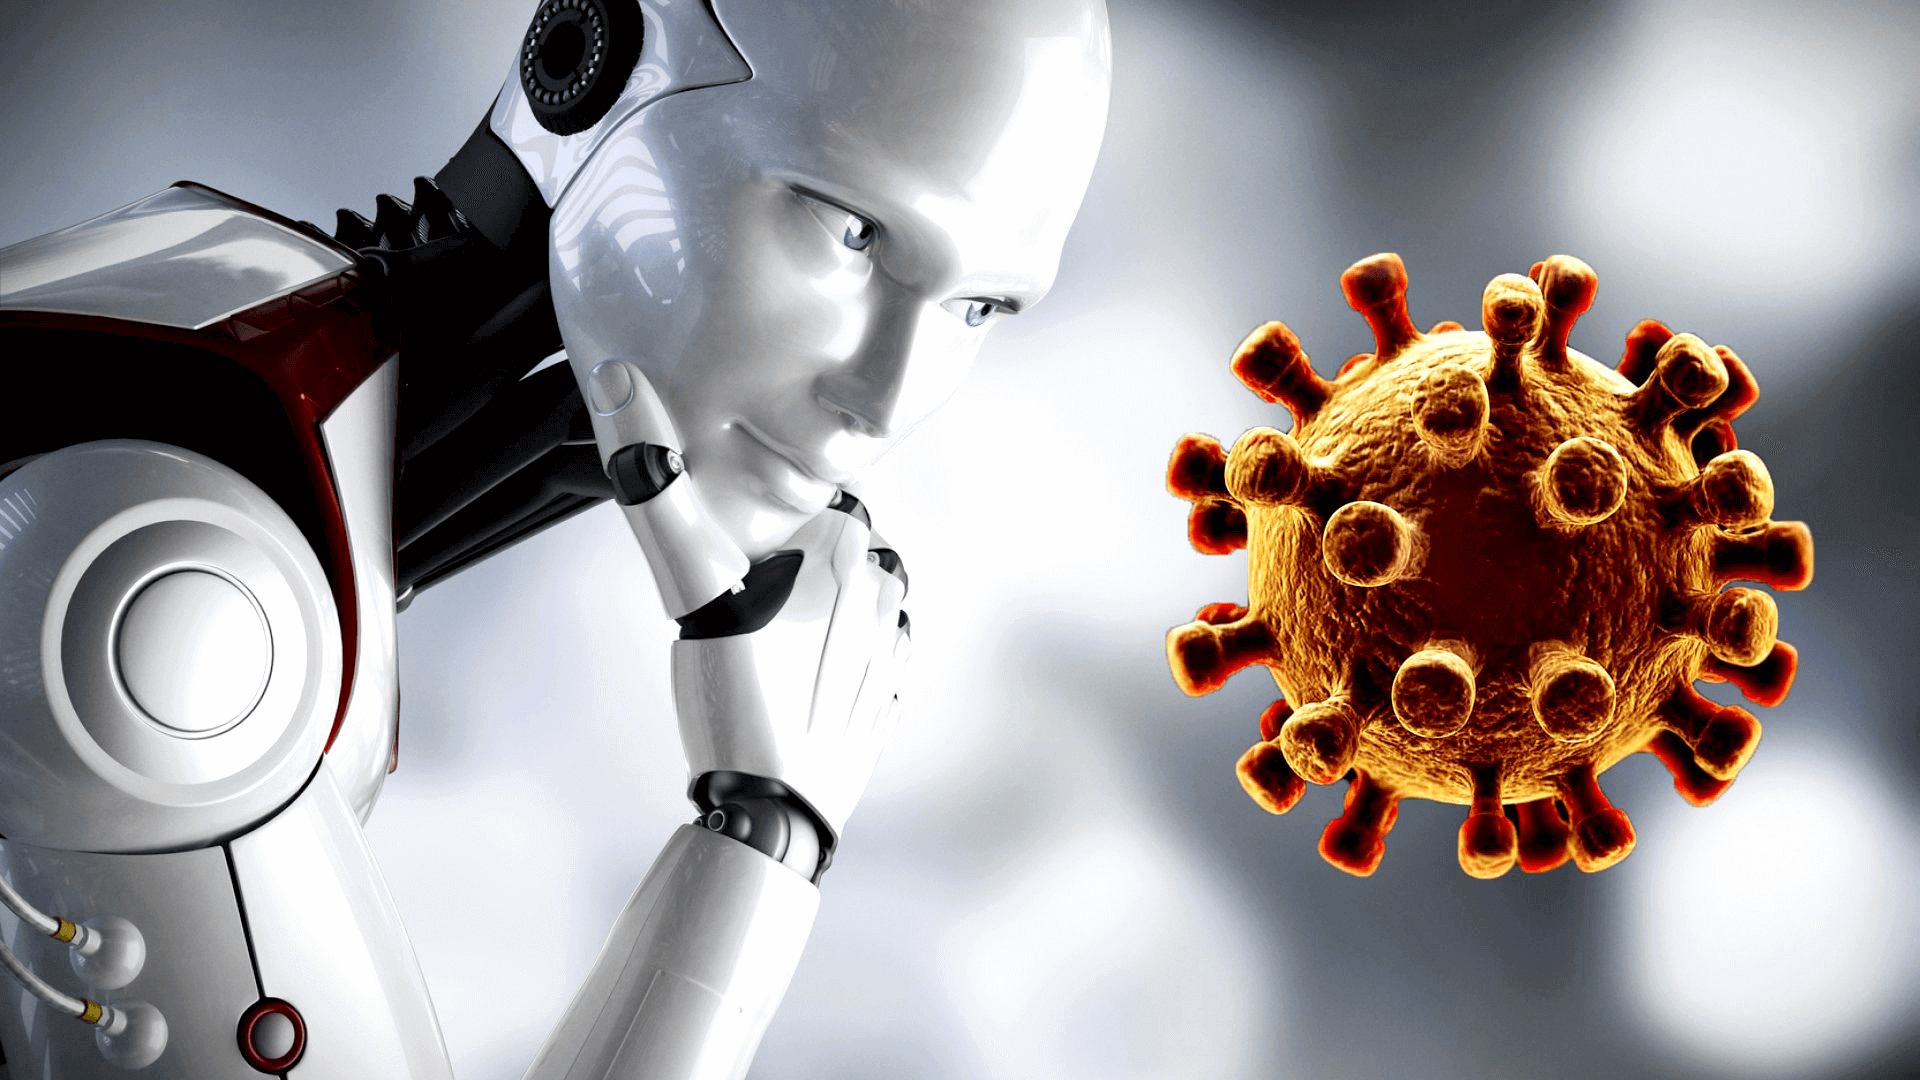

Мы будем изучать методы визуализации, используя два набора данных:

1. [covid_data](https://lms-cdn.skillfactory.ru/assets/courseware/v1/e8e401d5f46b6c4e81f7330cc24d4fe2/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/covid_data.zip) — данные о показателях заболеваемости за каждый день в различных регионах 187 стран. ([источник данных](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset))
   
   Мы будем работать со следующими столбцами:
    - **date** — дата наблюдения;
    - **province/state** — наименование провинции/штата;
    - **country** — наименование страны;
    - **confirmed** — общее число зафиксированных случаев на указанный день;
    - **deaths** — общее число зафиксированных смертей на указанный день;
    - **recovered** — общее число выздоровлений на указанный день.
  
  2. [country_vaccinations](https://lms-cdn.skillfactory.ru/assets/courseware/v1/4f12d963943a898af014981a4a822088/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/country_vaccinations.zip) — данные о процессе вакцинирования людей в 221 стране мира. ([источник данных](https://www.kaggle.com/gpreda/covid-world-vaccination-progress))
   
   Данная таблица содержит следующие столбцы:
   - **country** — наименование страны;
   - **date** — дата наблюдения;
   - **total_vaccinations** — общее число введённых вакцин в стране на указанный день;
   - **people_vaccinated** — общее число привитых первым компонентом в стране на указанный день;
   - **people_vaccinated_per_hundred** — процент привитых первым компонентом в стране на указанный день (рассчитывается как );
   - **people_fully_vaccinated** — общее число привитых вторым компонентом в стране на указанный день (первый компонент уже был введён им ранее);
   - **people_fully_vaccinated_per_hundred** — процент привитых вторым компонентом в стране на указанный день (рассчитывается как );
   - **daily_vaccination** — ежедневная вакцинация (число вакцинированных в указанный день);
   - **vaccines** — комбинации вакцин, используемые в стране.

In [1]:
import pandas as pd

covid_data = pd.read_csv('data/covid_data.csv')

vaccinations_data = pd.read_csv('data/country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]

### Немного об особенностях данных

В таблице **covid_data** данные о заболеваемости представлены для каждого региона (штата) страны за каждый день. 

Например, для США (United States) записи за 29 мая 2021 года имеют вид:

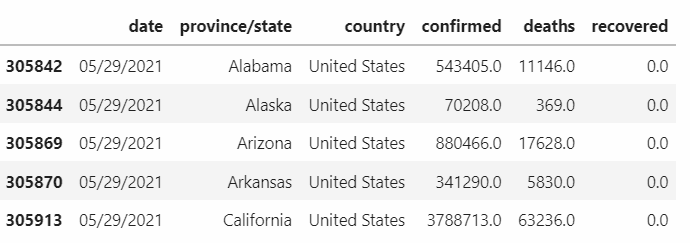

В таблице **vaccinations_data** параметры вакцинирования отображены для всех стран на каждый день, без учёта регионов. 

Вот часть таблицы для тех же Соединённых Штатов за 29 мая 2021 года. Как видите, она всего одна:
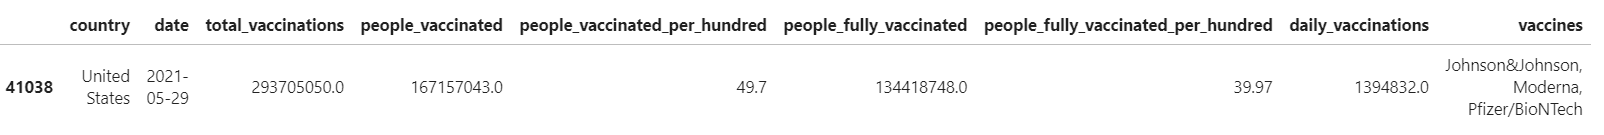

В данных много пропусков, а также неверно введённых значений. Например, для США (United States) и Великобритании (United Kingdom) в большинстве записей таблицы covid_data число выздоровевших людей равно 0. В данном модуле мы закроем на это глаза, но вообще эти страны подлежали бы исключению из данных или нам понадобился бы дополнительный источник данных, из которого мы смогли бы получить недостающую информацию.

Обратите внимание, что признаки *confirmed, deaths, recovered, total_vaccination, people_vaccinated, people_fully_vaccinated* — это суммарные показатели по стране, то есть с каждым днём они должны расти. Такие признаки называют накопительными.

Возникает большое желание объединить таблицы. Для этого необходимо учитывать следующие нюансы:

1. В таблице covid_data необходимо предварительно рассчитать суммарное ежедневное число заболевших во всех провинциях/штатах в каждой стране.
2. В таблицах не совпадает число стран, а иногда и их названия. 
3. При объединении таблиц по столбцу мы определённо теряем данные (в данной задаче потери незначительны). Избежать этого можно ручными преобразованиями данных — искать различия в названиях стран в таблицах и преобразовывать их. Однако это не является темой данного модуля.
4. Таблицы имеют разные периоды наблюдений (вакцины появились позже, чем сам вирус). Объединив данные с типом inner, мы можем потерять большое количество наблюдений в таблице covid_data.

### Предобработка данных

Опираясь на замечания выше, выполним небольшую предобработку.

В таблице covid_data:

In [ ]:
# Группируем таблицу по дате и названию страны и рассчитываем суммарные показатели по всем регионам. 
# Тем самым переходим от данных по регионам к данным по странам:

covid_data = covid_data.groupby(
    ['date','country'],
    as_index=False)[['confirmed','deaths','recovered']].sum()

In [ ]:
# Преобразуем даты в формат datetime с помощью функции pd.to_datetime():

covid_data['date'] = pd.to_datetime(covid_data['date'],dayfirst=False)

In [ ]:
# Создадим признак больных на данный момент (active). 
# Для этого вычтем из общего числа зафиксированных случаев число смертей и число выздоровевших пациентов:
covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

In [8]:
# Создадим признак ежедневного прироста числа заболевших, умерших и выздоровевших людей. 
# Для этого отсортируем данные по названиям стран, а затем по датам. 
# После этого произведём группировку по странам и 
# рассчитаем разницу между «вчера и сегодня» с помощью метода diff():

covid_data = covid_data.sort_values(by=['country','date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()

In [9]:
# Итоговый вид таблицы 
covid_data

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered
11337,2020-02-24,Afghanistan,1.0,0.0,0.0,1.0,NaN,NaN,NaN
11570,2020-02-25,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
11807,2020-02-26,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
12051,2020-02-27,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
12299,2020-02-28,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
15933,2020-03-12,occupied Palestinian territory,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16595,2020-03-14,occupied Palestinian territory,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16938,2020-03-15,occupied Palestinian territory,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17290,2020-03-16,occupied Palestinian territory,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# В таблице vaccinations_data достаточно будет преобразовать столбцы в формат datetime:
vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])

✍ Итак, мы произвели некоторую предобработку данных. Дальнейшее объединение таблиц остаётся за вами (обязательно выполните задания ниже, прежде чем двигаться дальше).

In [15]:
# Задание 3.1
# За какой период представлены данные в таблице covid_data? 
# В качестве ответа введите даты в формате datetime (без указания времени).
# Введите ответ в следующем формате (без пробелов): ГГГГ-ММ-ДД-ГГГГ-ММ-ДД

covid_data['date'].describe()

count                            86785
mean     2020-10-15 20:19:34.931151616
min                2020-01-22 00:00:00
25%                2020-06-25 00:00:00
50%                2020-10-17 00:00:00
75%                2021-02-07 00:00:00
max                2021-05-29 00:00:00
Name: date, dtype: object

In [16]:
# Задание 3.2
# За какой период представлены данные в таблице vaccinations_data? 
# В качестве ответа введите даты в формате datetime без указания времени.
# Введите ответ в следующем формате (без пробелов): ГГГГ-ММ-ДД-ГГГГ-ММ-ДД

vaccinations_data['date'].describe()

count                            42795
mean     2021-05-21 12:12:46.182965248
min                2020-12-02 00:00:00
25%                2021-04-02 00:00:00
50%                2021-05-26 00:00:00
75%                2021-07-15 00:00:00
max                2021-09-06 00:00:00
Name: date, dtype: object

In [18]:
# Задание 3.3
# С помощью метода merge() объедините таблицы covid_data и vaccinations_data по столбцам date и country.
# Тип объединения выставьте так, чтобы в результирующую таблицу попали только наблюдения за период, вычисленный в задании 3.1. 
# То есть в результирующую таблицу должны попасть все записи из таблицы covid_data и из её пересечения с vaccinations_data, 
# но не более. Результат объединения занесите в переменную covid_df.

covid_df = covid_data.merge(
    vaccinations_data,
    how='left',
    on=['date','country']
)

# Сохраните таблицу covid_df — она понадобится нам в следующем юните.

covid_df.to_csv('data/covid_df.csv')

In [19]:
# Сколько строк и столбцов в таблице covid_df?
# Введите ответ в виде двух чисел через дефис (например, 333-33): 
# первое число — количество строк, второе число — количество столбцов.

covid_df.shape

(86785, 16)

In [20]:
# В получившейся в задании 3.3 таблице covid_df создайте признаки 
# death_rate — общий процент смертей среди зафиксированных случаев (летальность) и 
# recover_rate — общий процент случаев выздоровления. 
# Данные характеристики рассчитайте как отношение числа смертей (deaths) и числа выздоровлений (recovered) к 
# числу зафиксированных случаев (confirmed) и умножьте результаты на 100%.

covid_df['death_rate'] = covid_df['deaths']/covid_df['confirmed']*100

covid_df['recover_rate'] = covid_df['recovered']/covid_df['confirmed']*100

In [41]:
# Задание 3.4
# Какова максимальная летальность в США (United States) за весь период? 
# Ответ округлите до второго знака после запятой.

mask = covid_df['country'] == 'United States'

covid_df[mask]['death_rate'].describe()

count    494.000000
mean       2.723727
std        1.612642
min        0.000000
25%        1.779922
50%        2.102579
75%        3.329684
max        7.189542
Name: death_rate, dtype: float64

In [42]:
# Задание 3.5
# Чему равен средний процент выздоровевших в России (Russia)? 
# Ответ округлите до второго знака после запятой.

mask = covid_df['country'] == 'Russia'

covid_df[mask]['recover_rate'].describe()

count    485.000000
mean      67.062735
std       29.904159
min        0.000000
25%       58.134801
50%       79.358398
75%       88.428421
max      100.000000
Name: recover_rate, dtype: float64